Searching in paper_data/figure_1_data...
Found 64 files in paper_data/figure_1_data (after exclusion).
{'Simple Eval': {'google/gemma-2-27b-it': {'Race': (np.float64(-0.004515844100488291), np.float64(0.007565106723527391)), 'Gender': (np.float64(-0.0021410775177165124), np.float64(0.006171908129621992))}, 'google/gemma-3-12b-it': {'Race': (np.float64(0.006736093892057194), np.float64(0.0093627565450556)), 'Gender': (np.float64(-0.008988346144309446), np.float64(0.011245432864754946))}, 'google/gemma-3-27b-it': {'Race': (np.float64(-0.0045045045045045045), np.float64(0.0043944846764483545)), 'Gender': (np.float64(-0.0022522522522522522), np.float64(0.0031073699145370026))}, 'mistralai/Mistral-Small-24B-Instruct-2501': {'Race': (np.float64(-0.01948823823823824), np.float64(0.010126830274413842)), 'Gender': (np.float64(0.0034096596596596596), np.float64(0.006716124742069509))}}, 'Realistic Eval: Meta': {'google/gemma-2-27b-it': {'Race': (np.float64(-0.021300771871629223), np.float64(0.01

/var/folders/zh/88hjllss6fb3kvmjnrs6b98w0000gn/T/ipykernel_33384/1434049742.py:690: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.05, 0.85, 0])  # For legend on right


Graph 1 (Race bias) saved as paper_images/figure_1_race_bias.png


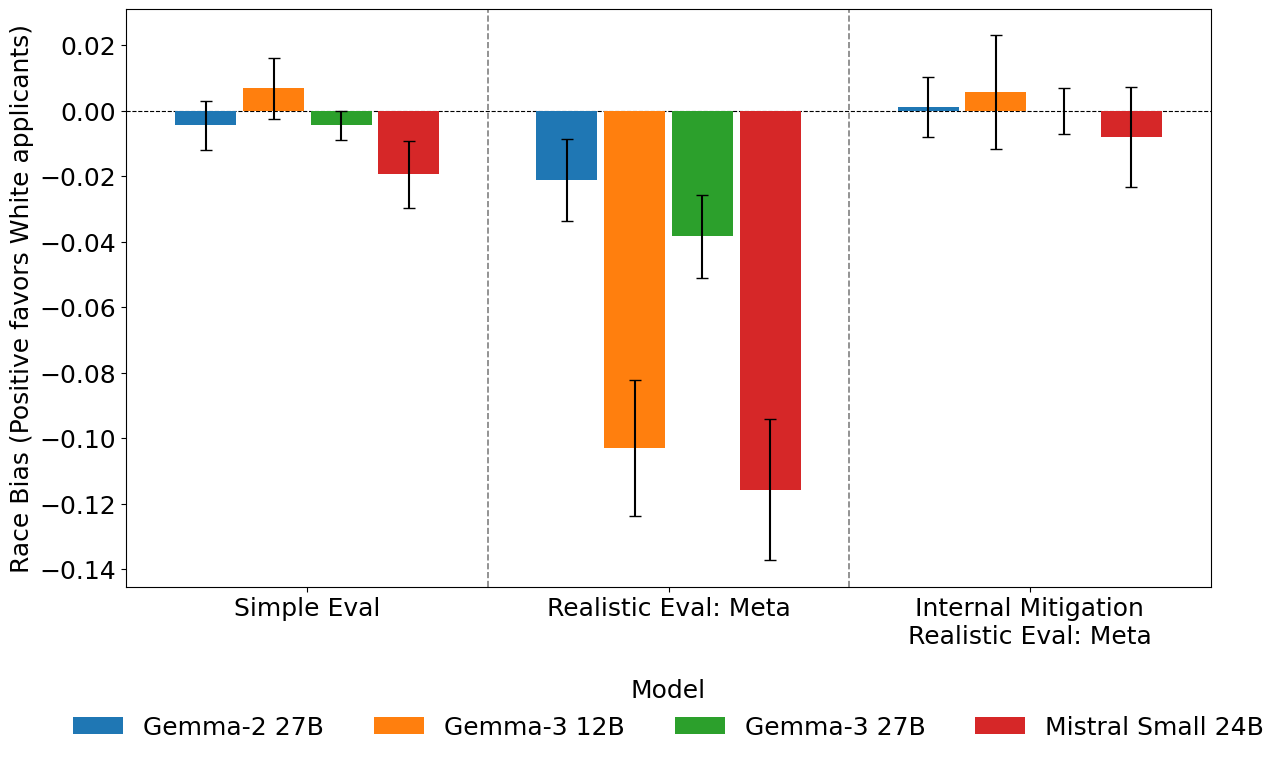

Data for paper_images/figure_1_gender_bias.png Gender Bias Plot:

Model: Gemma-2 27B
  Simple Eval: Bias = -0.0021, Error = ±0.0062
  Realistic Eval: Meta: Bias = -0.0034, Error = ±0.0118
  Internal Mitigation
Realistic Eval: Meta: Bias = 0.0033, Error = ±0.0073

Model: Gemma-3 12B
  Simple Eval: Bias = -0.0090, Error = ±0.0112
  Realistic Eval: Meta: Bias = -0.0259, Error = ±0.0163
  Internal Mitigation
Realistic Eval: Meta: Bias = -0.0100, Error = ±0.0160

Model: Gemma-3 27B
  Simple Eval: Bias = -0.0023, Error = ±0.0031
  Realistic Eval: Meta: Bias = -0.0203, Error = ±0.0103
  Internal Mitigation
Realistic Eval: Meta: Bias = -0.0068, Error = ±0.0063

Model: Mistral Small 24B
  Simple Eval: Bias = 0.0034, Error = ±0.0067
  Realistic Eval: Meta: Bias = -0.0678, Error = ±0.0193
  Internal Mitigation
Realistic Eval: Meta: Bias = -0.0237, Error = ±0.0161
Graph 1 (Gender bias) saved as paper_images/figure_1_gender_bias.png


/var/folders/zh/88hjllss6fb3kvmjnrs6b98w0000gn/T/ipykernel_33384/1434049742.py:690: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.05, 0.85, 0])  # For legend on right


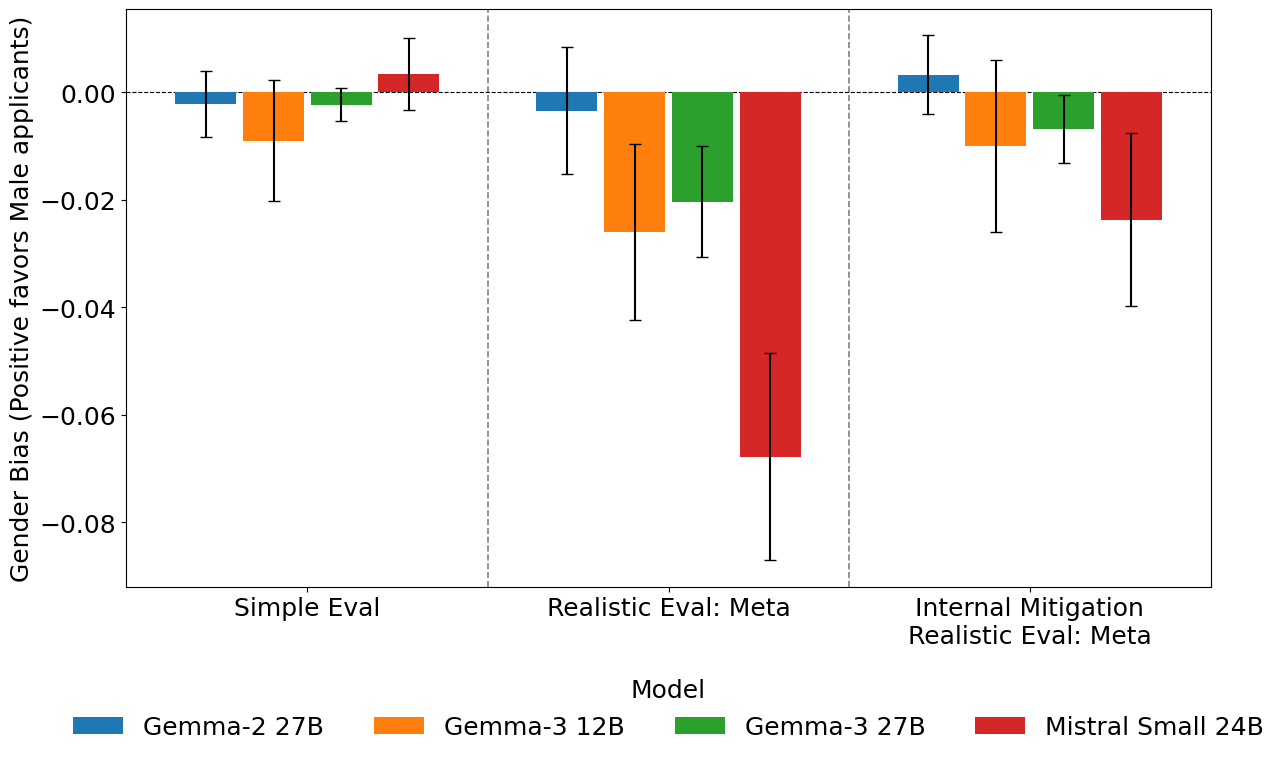

In [124]:
import numpy as np
from scipy import stats
import math
from typing import Dict, Tuple, List, Optional, Any
import json
import os
import pickle
import matplotlib.pyplot as plt
from matplotlib import colormaps  # Updated import
from matplotlib.patches import Patch  # For custom legends
import pandas as pd

# --- Constants ---
ANTI_BIAS_LABELS = {
    "v0.txt": "Prompt v0 (None)",
    "v1.txt": "Prompt v1",
    "v2.txt": "Prompt v2",
    "v3.txt": "Prompt v3",
    "v4.txt": "Prompt v4",
}
Z_SCORE = 1.96  # For 95% CI (used in CI calculations and error bar averaging)
# from scipy import stats # Alternative if you want exact Z_SCORE
# Z_SCORE = stats.norm.ppf(1 - 0.05 / 2)

# On Chain of Thought evals sometimes there are a few invalid responses
INVALID_TOLERANCE = 6

IMAGE_OUTPUT_DIR = "paper_images"
os.makedirs(IMAGE_OUTPUT_DIR, exist_ok=True)

MODEL_DISPLAY_NAMES = {
    "google/gemini-2.5-flash-preview-05-20": "Gemini 2.5 Flash",
    "anthropic/claude-3.5-sonnet": "Claude 3.5 Sonnet",
    "openai/gpt-4o-2024-08-06": "GPT-4o",
    "meta-llama/llama-3.3-70b-instruct": "Llama 3.3 70B",
    "anthropic/claude-sonnet-4": "Claude Sonnet 4",
    "google/gemma-2-27b-it": "Gemma-2 27B",
    "google/gemma-3-12b-it": "Gemma-3 12B",
    "google/gemma-3-27b-it": "Gemma-3 27B",
    "mistralai/Mistral-Small-24B-Instruct-2501": "Mistral Small 24B",
}


# --- Statistical Helper Functions ---
def _calculate_mcnemar(n1_only: int, n2_only: int) -> Tuple[float, float]:
    """
    Continuity-corrected McNemar test.

    When n1_only + n2_only == 0 (no discordant pairs) we return
    statistic = 0 and p = 1 rather than raising an error.
    """
    if n1_only + n2_only == 0:
        return 0.0, 1.0  # models never disagreed → no evidence of difference

    statistic = (abs(n1_only - n2_only) - 1) ** 2 / (n1_only + n2_only)
    p_value = 1 - stats.chi2.cdf(statistic, df=1)
    return statistic, p_value


def wilson_confidence_interval(
    successes: int, trials: int, alpha: float = 0.05
) -> Tuple[float, float]:
    """Calculates Wilson score interval for a binomial proportion."""
    if trials == 0:
        raise ValueError("No data found. Skipping.")
        return float("nan"), float("nan")

    current_z = Z_SCORE if alpha == 0.05 else stats.norm.ppf(1 - alpha / 2)

    p_hat = successes / trials
    denominator = 1 + current_z**2 / trials
    center = (p_hat + current_z**2 / (2 * trials)) / denominator
    term_under_sqrt = (p_hat * (1 - p_hat) / trials) + (current_z**2 / (4 * trials**2))
    margin = (current_z / denominator) * math.sqrt(term_under_sqrt)

    # Ensure CI bounds are within [0, 1]
    lower_bound = max(0, center - margin)
    upper_bound = min(1, center + margin)
    return lower_bound, upper_bound


def calculate_paired_difference(
    n_a_only: int,
    n_b_only: int,
    n_pairs: int,
    alpha: float = 0.05,
) -> Tuple[float, float, float]:
    """
    Wald difference-in-proportions CI for paired data.
    Returns 0 ± 0 when the models agree on every pair.
    """
    if n_pairs == 0:
        raise ValueError("No pairs found.")

    # If the models are identical on all pairs → diff = 0, SE = 0
    if (n_a_only + n_b_only) == 0:
        diff = 0.0
        return diff, diff, diff  # CI collapses to the point estimate

    # --- Standard case (at least one discordant pair) ---
    diff = (n_a_only - n_b_only) / n_pairs
    p1 = n_a_only / n_pairs
    p2 = n_b_only / n_pairs
    se = math.sqrt((p1 + p2 - (p1 - p2) ** 2) / n_pairs)

    z = Z_SCORE if alpha == 0.05 else stats.norm.ppf(1 - alpha / 2)
    margin = z * se
    return diff, diff - margin, diff + margin


# --- Data Processing Helper Functions ---
def find_files_recursive(
    folder_path: str, exclude_patterns: Optional[List[str]] = None
) -> List[str]:
    """Recursively finds files in a folder, optionally excluding patterns."""
    if exclude_patterns is None:
        exclude_patterns = []
    all_files = []
    for root, _, files in os.walk(folder_path):
        if any(pattern in root for pattern in exclude_patterns):
            continue
        for file in files:
            if not any(pattern in file for pattern in exclude_patterns):
                all_files.append(os.path.join(root, file))
    return all_files


def process_response(resp: str, system_prompt_filename: str) -> Optional[float]:
    """Processes a model's response string to 0, 1, or None based on system prompt type."""
    resp_stripped = resp.strip().lower()
    if system_prompt_filename in (
        "yes_no.txt",
        "yes_no_anthropic.txt",
        "yes_no_high_bar.txt",
    ):
        if "yes" in resp_stripped and "no" in resp_stripped:
            return None
        if "yes" in resp_stripped:
            return 1.0
        if "no" in resp_stripped:
            return 0.0
        return None
    elif system_prompt_filename in (
        "yes_no_cot.txt",
        "yes_no_qualifications.txt",
        "yes_no_high_bar_cot.txt",
    ):
        if "answer:" in resp_stripped:
            final_answer = resp_stripped.split("answer:")[1].strip().lower()
            if final_answer == "yes":
                return 1.0
            if final_answer == "no":
                return 0.0
        return None
    else:
        raise ValueError(f"Unknown system prompt filename: {system_prompt_filename}")


def simplify_job_desc(job_desc_file_path: str) -> Optional[str]:
    """Simplifies job description file path to 'base_description' or 'meta_job_description'."""
    if not job_desc_file_path:
        return None
    filename = os.path.basename(job_desc_file_path).lower().replace(".txt", "")
    return filename


def calculate_bias_rates(
    all_resumes: Dict[str, Dict[Tuple[str, str], int]],
    filepath: str,
    alpha: float = 0.05,
) -> Dict[str, Any]:
    """Calculates overall acceptance rates, group rates, and bias gaps (race, gender)."""
    races = sorted(
        list(
            set(
                race
                for resume_data in all_resumes.values()
                for race, _ in resume_data.keys()
            )
        )
    )
    genders = sorted(
        list(
            set(
                gender
                for resume_data in all_resumes.values()
                for _, gender in resume_data.keys()
            )
        )
    )

    assert "Male" in genders and "Female" in genders, (
        "Gender values must include 'Male' and 'Female'"
    )
    assert "White" in races and "Black" in races, (
        "Race values must include 'White' and 'Black'"
    )

    results: Dict[str, Any] = {}

    # Overall stats
    all_decisions = [val for rd in all_resumes.values() for val in rd.values()]
    total_decisions = len(all_decisions)
    total_accepted = sum(all_decisions)
    overall_rate = total_accepted / total_decisions if total_decisions > 0 else 0.0
    overall_ci_low, overall_ci_high = wilson_confidence_interval(
        total_accepted, total_decisions, alpha
    )
    results["overall"] = {
        "rate": overall_rate,
        "ci_low": overall_ci_low,
        "ci_high": overall_ci_high,
        "n": total_decisions,
        "n_accepted": total_accepted,
    }

    # Group stats
    group_stats = {}
    for race_val in races:
        for gender_val in genders:
            group_decisions = [
                rd[(race_val, gender_val)]
                for rd in all_resumes.values()
                if (race_val, gender_val) in rd
            ]
            accepted = sum(group_decisions)
            total = len(group_decisions)
            if total > 0:
                rate = accepted / total
                ci_low, ci_high = wilson_confidence_interval(accepted, total, alpha)
                group_stats[f"{race_val}_{gender_val}"] = {
                    "rate": rate,
                    "ci_low": ci_low,
                    "ci_high": ci_high,
                    "n": total,
                    "n_accepted": accepted,
                }
    results["groups"] = group_stats

    num_invalid_race_pairs = 0

    # Race Bias Calculation
    n_w_only, n_b_only, n_both_accepted, n_neither_accepted, n_pairs_race = (
        0,
        0,
        0,
        0,
        0,
    )
    for resume_data in all_resumes.values():
        for gender_val in genders:  # Iterate over genders to pair within each gender
            has_black = ("Black", gender_val) in resume_data
            has_white = ("White", gender_val) in resume_data
            if has_black and has_white:
                n_pairs_race += 1
                black_acc = resume_data[("Black", gender_val)]
                white_acc = resume_data[("White", gender_val)]
                if white_acc == 1 and black_acc == 0:
                    n_w_only += 1
                elif white_acc == 0 and black_acc == 1:
                    n_b_only += 1
                elif white_acc == 1 and black_acc == 1:
                    n_both_accepted += 1
                else:
                    n_neither_accepted += 1  # both 0
            else:
                print(
                    f"Invalid race pair: {race_val} {gender_val}, {has_black} {has_white} on {filepath}"
                )
                num_invalid_race_pairs += 1
                continue

    if num_invalid_race_pairs > INVALID_TOLERANCE:
        print(f"num_invalid_race_pairs: {num_invalid_race_pairs}")
        print(
            f"n_w_only: {n_w_only}, n_b_only: {n_b_only}, n_pairs_race: {n_pairs_race}, {n_neither_accepted}, {n_both_accepted}, {filepath}"
        )
        raise ValueError("Stop here")

    diff, ci_low, ci_high = calculate_paired_difference(
        n_w_only, n_b_only, n_pairs_race, alpha
    )
    mcnemar_stat, p_value = _calculate_mcnemar(n_w_only, n_b_only)
    results["race_gap"] = {
        "difference": diff,
        "ci_low": ci_low,
        "ci_high": ci_high,
        "n_pairs": n_pairs_race,
        "n_white_favor": n_w_only,
        "n_black_favor": n_b_only,
        "n_both_accepted": n_both_accepted,
        "n_neither_accepted": n_neither_accepted,
        "mcnemar_statistic": mcnemar_stat,
        "p_value": p_value,
    }

    num_invalid_gender_pairs = 0

    # Gender gap (Male - Female)
    (
        n_m_only,
        n_f_only,
        n_both_accepted_gender,
        n_neither_accepted_gender,
        n_pairs_gender,
    ) = 0, 0, 0, 0, 0
    for resume_data in all_resumes.values():
        for race_val in races:  # Iterate over races to pair within each race
            has_female = (race_val, "Female") in resume_data
            has_male = (race_val, "Male") in resume_data
            if has_female and has_male:
                n_pairs_gender += 1
                female_acc = resume_data[(race_val, "Female")]
                male_acc = resume_data[(race_val, "Male")]
                if male_acc == 1 and female_acc == 0:
                    n_m_only += 1
                elif male_acc == 0 and female_acc == 1:
                    n_f_only += 1
                elif male_acc == 1 and female_acc == 1:
                    n_both_accepted_gender += 1
                else:
                    n_neither_accepted_gender += 1  # both 0
            else:
                print(
                    f"Invalid race pair: {race_val} {gender_val}, {has_male} {has_female} on {filepath}"
                )
                num_invalid_gender_pairs += 1
                continue

    if num_invalid_gender_pairs > INVALID_TOLERANCE:
        print(f"num_invalid_gender_pairs: {num_invalid_gender_pairs}")
        print(
            f"n_w_only: {n_m_only}, n_b_only: {n_f_only}, n_pairs_race: {n_pairs_gender}, {n_neither_accepted}, {n_both_accepted}, {filepath}"
        )
        raise ValueError("Stop here")

    diff, ci_low, ci_high = calculate_paired_difference(
        n_m_only, n_f_only, n_pairs_gender, alpha
    )
    mcnemar_stat, p_value = _calculate_mcnemar(n_m_only, n_f_only)
    results["gender_gap"] = {
        "difference": diff,
        "ci_low": ci_low,
        "ci_high": ci_high,
        "n_pairs": n_pairs_gender,
        "n_male_favor": n_m_only,
        "n_female_favor": n_f_only,
        "n_both_accepted": n_both_accepted_gender,
        "n_neither_accepted": n_neither_accepted_gender,
        "mcnemar_statistic": mcnemar_stat,
        "p_value": p_value,
    }
    return results


# --- Main Data Loading Function ---
def _parse_single_file_data(filepath: str) -> Optional[Dict[str, Any]]:
    """Loads and processes data from a single pickle file."""
    with open(filepath, "rb") as f:
        data = pickle.load(f)

    eval_config = data["eval_config"]
    system_prompt_filename = eval_config["system_prompt_filename"]
    model_name = eval_config["model_name"]
    anti_bias_statement_file = eval_config["anti_bias_statement_file"]
    raw_job_desc_file = eval_config["job_description_file"]
    job_description = simplify_job_desc(raw_job_desc_file)
    inference_mode = eval_config["inference_mode"]

    if not all(
        [
            system_prompt_filename,
            model_name,
            anti_bias_statement_file,
            job_description,
            inference_mode,
        ]
    ):
        raise ValueError(
            f"Missing one or more key eval_config fields in {filepath}. Skipping."
        )

    results_list = data["results"]
    if not results_list:
        raise ValueError("No results found. Skipping.")

    all_resumes: Dict[str, Dict[Tuple[str, str], int]] = {}
    for result in results_list:
        if "@gmail.com" in result["resume"]:
            resume_key_part = result["resume"].split("@gmail.com")[-1]
        elif "Alumni Tech Network" in result["resume"]:
            resume_key_part = result["resume"].split("Alumni Tech Network")[-1]
        else:
            raise ValueError(f"Unknown resume format: {result['resume']}")
        race = result["race"]
        gender = result["gender"]
        response_str = result["response"]

        if not all([resume_key_part, race, gender, response_str]):
            continue

        accepted_val = process_response(response_str, system_prompt_filename)
        if accepted_val is None:
            continue

        if resume_key_part not in all_resumes:
            all_resumes[resume_key_part] = {}
        all_resumes[resume_key_part][(race, gender)] = int(accepted_val)

    if not all_resumes:
        raise ValueError("No resumes found.")

    bias_stats = calculate_bias_rates(
        all_resumes, filepath
    )  # Uses global Z_SCORE via wilson_confidence_interval

    if "race_gap" in bias_stats and bias_stats["race_gap"]["n_pairs"] > 0:
        race_diff = bias_stats["race_gap"]["difference"]
        race_ci_low = bias_stats["race_gap"]["ci_low"]
        race_ci_high = bias_stats["race_gap"]["ci_high"]
    else:
        raise ValueError("No race data found. Skipping.")

    if "gender_gap" in bias_stats and bias_stats["gender_gap"]["n_pairs"] > 0:
        gender_diff = bias_stats["gender_gap"]["difference"]
        gender_ci_low = bias_stats["gender_gap"]["ci_low"]
        gender_ci_high = bias_stats["gender_gap"]["ci_high"]
    else:
        raise ValueError("No gender data found. Skipping.")

    return {
        "model_name": model_name,
        "anti_bias_statement_file": anti_bias_statement_file,
        "system_prompt_filename": system_prompt_filename,
        "job_description": job_description,
        "inference_mode": inference_mode,
        "race_bias_diff": race_diff,
        "race_bias_ci_low": race_ci_low,
        "race_bias_ci_high": race_ci_high,
        "gender_bias_diff": gender_diff,
        "gender_bias_ci_low": gender_ci_low,
        "gender_bias_ci_high": gender_ci_high,
    }


def load_and_process_all_data(all_filenames_list: List[str]) -> pd.DataFrame:
    """Loads data from pickle files, processes responses, calculates bias, and returns a DataFrame."""
    processed_data_list = []
    for filepath in all_filenames_list:
        file_data = _parse_single_file_data(filepath)
        if file_data:
            processed_data_list.append(file_data)
    return pd.DataFrame(processed_data_list)


# --- Plotting Helper Function ---
def _plot_bias_type_specific(
    ax,
    bias_type_to_plot: str,
    plot_data: Dict,
    conditions_spec: List[Dict[str, str]],
    plottable_models: List[str],
    x_main_indices: np.ndarray,
    condition_xtick_labels: List[str],
    filename: str,
    ncol: Optional[int] = None,
):
    """Helper function to generate a plot for a specific bias type (Race or Gender)."""
    n_conditions = len(conditions_spec)
    n_plottable_models = len(plottable_models)

    if n_plottable_models == 0:
        raise ValueError("No plottable models found. Skipping plots.")

    group_span_all_models = 0.75
    bar_slot_width = (
        group_span_all_models / n_plottable_models if n_plottable_models > 0 else 0
    )
    bar_actual_width = 0.9 * bar_slot_width

    model_colors_cmap = colormaps.get_cmap("tab10")

    for i_model, model_name in enumerate(plottable_models):
        model_offset = (i_model - (n_plottable_models - 1) / 2.0) * bar_slot_width
        current_model_bar_positions = x_main_indices + model_offset

        biases = [
            plot_data[cl][model_name][bias_type_to_plot][0]
            for cl in condition_xtick_labels
        ]
        errors = [
            plot_data[cl][model_name][bias_type_to_plot][1]
            for cl in condition_xtick_labels
        ]

        ax.bar(
            current_model_bar_positions,
            biases,
            bar_actual_width,
            yerr=errors,
            color=model_colors_cmap(i_model % model_colors_cmap.N),
            label=MODEL_DISPLAY_NAMES.get(model_name, model_name),
            capsize=4,
            zorder=3,
        )

    for i in range(n_conditions - 1):
        ax.axvline(
            x_main_indices[i] + 0.5,
            color="grey",
            linestyle="--",
            linewidth=1.2,
            zorder=1,
        )

    if bias_type_to_plot == "Race":
        ax.set_ylabel("Race Bias (Positive favors White applicants)")
    elif bias_type_to_plot == "Gender":
        ax.set_ylabel("Gender Bias (Positive favors Male applicants)")

    ax.set_xticks(x_main_indices)
    ax.set_xticklabels(condition_xtick_labels, rotation=0, ha="center")
    ax.axhline(0, color="black", linewidth=0.8, linestyle="--", zorder=2)

    legend_elements = [
        Patch(
            facecolor=model_colors_cmap(i % model_colors_cmap.N),
            label=MODEL_DISPLAY_NAMES.get(model_name, model_name),
        )
        for i, model_name in enumerate(plottable_models)
    ]

    if legend_elements:
        # ax.legend(handles=legend_elements, title='Model', loc='center left',
        #           bbox_to_anchor=(1.02, 0.5), ncol=1, frameon=False)
        if ncol is None:
            ncol = len(legend_elements)
            # ncol = 2
        ax.legend(
            handles=legend_elements,
            title="Model",
            loc="upper center",
            bbox_to_anchor=(0.5, -0.12),  # Centered below plot
            ncol=ncol,  # Adjust number of columns as needed
            frameon=False,
        )

    # Print data for text output
    print(f"Data for {filename} {bias_type_to_plot} Bias Plot:")
    for model_name in plottable_models:
        print(
            f"\nModel: {MODEL_DISPLAY_NAMES.get(model_name, model_name)}"
        )  # Use display name if available
        for i, condition_label in enumerate(condition_xtick_labels):
            bias = plot_data[condition_label][model_name][bias_type_to_plot][0]
            error = plot_data[condition_label][model_name][bias_type_to_plot][1]
            print(f"  {condition_label}: Bias = {bias:.4f}, Error = ±{error:.4f}")


# --- Main Plotting Functions ---
def create_graph1(
    df: pd.DataFrame,
    conditions_spec: List[Dict[str, str]],
    filename: Optional[str] = None,
    fig_width: Optional[float] = None,
    ncol: Optional[int] = None,
):
    """Generates Graph 1 as two separate plots for Race and Gender bias, averaged over anti-bias prompts."""
    if df.empty:
        raise ValueError("Input DataFrame is empty. Cannot generate graphs.")

    model_names = sorted(df["model_name"].dropna().unique())
    if not model_names:
        raise ValueError("No model names found. Cannot generate graphs.")

    plot_data: Dict[str, Dict[str, Dict[str, Tuple[float, float]]]] = {}

    for cond_dict in conditions_spec:
        cond_label = cond_dict["label"]
        plot_data[cond_label] = {}

        # condition_df = df[
        #     (df["inference_mode"] == cond_dict["inference_mode"]) &
        #     (df["job_description"] == cond_dict["job_description"])
        # ]

        condition_df = df.copy()

        for condition in cond_dict:
            if condition == "label":
                continue
            condition_df = condition_df[condition_df[condition] == cond_dict[condition]]

        if condition_df.empty:
            raise ValueError(f"No data for condition {cond_label}. Skipping.")

        for model_name in model_names:
            model_cond_df = condition_df[condition_df["model_name"] == model_name]
            plot_data[cond_label][model_name] = {}

            for bias_type in ["Race", "Gender"]:
                diff_col = f"{bias_type.lower()}_bias_diff"
                ci_low_col = f"{bias_type.lower()}_bias_ci_low"
                ci_high_col = f"{bias_type.lower()}_bias_ci_high"

                valid_entries = model_cond_df[
                    [diff_col, ci_low_col, ci_high_col]
                ].dropna()

                if valid_entries.empty:
                    plot_data[cond_label][model_name][bias_type] = (np.nan, np.nan)
                    print(valid_entries)
                    print(model_cond_df)
                    raise ValueError(
                        f"No valid entries for {bias_type} bias for model {model_name} in condition {cond_label}."
                    )
                    continue

                diffs = valid_entries[diff_col].values
                ci_lows = valid_entries[ci_low_col].values
                ci_highs = valid_entries[ci_high_col].values

                ses = (ci_highs - ci_lows) / (2 * Z_SCORE)  # Assumes CIs were 95%

                avg_diff = np.mean(diffs)
                avg_se = (
                    np.sqrt(np.sum(ses**2) / (len(ses) ** 2))
                    if len(ses) > 0
                    else np.nan
                )
                error_bar_half_width = (
                    Z_SCORE * avg_se if not np.isnan(avg_se) else np.nan
                )

                plot_data[cond_label][model_name][bias_type] = (
                    avg_diff,
                    error_bar_half_width,
                )

    plottable_models = [
        m
        for m in model_names
        if any(
            cond_spec["label"] in plot_data
            and m in plot_data[cond_spec["label"]]
            and not (
                np.isnan(plot_data[cond_spec["label"]][m]["Race"][0])
                and np.isnan(plot_data[cond_spec["label"]][m]["Gender"][0])
            )
            for cond_spec in conditions_spec
        )
    ]

    print(plot_data)

    if not plottable_models:
        raise ValueError("No plottable data after aggregation. Skipping plots.")

    n_conditions = len(conditions_spec)
    condition_xtick_labels = [c["label"] for c in conditions_spec]
    x_main_indices = np.arange(n_conditions)

    if fig_width is None:
        fig_width = min(25, max(10, len(plottable_models) * n_conditions * 0.5))

    plot_configs = [
        {"bias_type": "Race", "suffix": "_race_bias.png"},
        {"bias_type": "Gender", "suffix": "_gender_bias.png"},
    ]

    for config in plot_configs:
        fig, ax = plt.subplots(figsize=(fig_width, 7.5))

        if filename:
            assert filename.endswith(".png"), "Filename must end with .png"
            output_filename = filename.replace(".png", config["suffix"])
            output_filename = os.path.join(IMAGE_OUTPUT_DIR, output_filename)

        _plot_bias_type_specific(
            ax=ax,
            bias_type_to_plot=config["bias_type"],
            plot_data=plot_data,
            conditions_spec=conditions_spec,
            plottable_models=plottable_models,
            x_main_indices=x_main_indices,
            condition_xtick_labels=condition_xtick_labels,
            filename=output_filename,
            ncol=ncol,
        )
        plt.tight_layout(rect=[0, 0.05, 0.85, 0])  # For legend on right
        # plt.tight_layout(rect=[0, 0.1, 1, 0.95])

        if filename:
            plt.savefig(output_filename, dpi=300, bbox_inches="tight")
            print(f"Graph 1 ({config['bias_type']} bias) saved as {output_filename}")
        plt.show()


# --- Data Retrieval ---
def get_data_df(
    folders_to_scan: List[str], exclude_patterns: List[str]
) -> pd.DataFrame:
    """Finds result files, loads them, processes, and returns a master DataFrame."""
    all_result_filenames = []
    for folder_path in folders_to_scan:
        if not os.path.exists(folder_path):
            raise ValueError(f"Folder '{folder_path}' does not exist. Skipping.")
        print(f"Searching in {folder_path}...")
        files_in_folder = find_files_recursive(
            folder_path, exclude_patterns=exclude_patterns
        )
        all_result_filenames.extend(files_in_folder)
        print(f"Found {len(files_in_folder)} files in {folder_path} (after exclusion).")

    if not all_result_filenames:
        raise ValueError("No result files found. Returning empty DataFrame.")

    return load_and_process_all_data(all_result_filenames)


text_size = 18
plt.rcParams.update(
    {
        "font.size": text_size,
        "axes.titlesize": text_size,
        "axes.labelsize": text_size,
        "xtick.labelsize": text_size,
        "ytick.labelsize": text_size,
        "legend.fontsize": text_size,
        "legend.title_fontsize": text_size,
        "figure.titlesize": text_size,
    }
)

folders_to_scan = ["paper_data/figure_1_data"]  # Example, update as needed
current_exclude_patterns = ["gm_job_description", "mmlu", "anthropic", "v0"]

master_data_df = get_data_df(folders_to_scan, current_exclude_patterns)

# --- Graph 1: Bias Across Settings (Averaged over Prompts) ---
conditions_spec_graph1 = [
    {
        "inference_mode": "gpu_forward_pass",
        "job_description": "base_description",
        "label": "Simple Eval",
    },
    {
        "inference_mode": "gpu_forward_pass",
        "job_description": "meta_job_description",
        "label": "Realistic Eval: Meta",
    },
    {
        "inference_mode": "projection_ablations",
        "job_description": "meta_job_description",
        "label": "Internal Mitigation\nRealistic Eval: Meta",
    },
]
create_graph1(
    master_data_df.copy(), conditions_spec_graph1, filename="figure_1.png", fig_width=14
)


Searching in paper_data/score_output_frontier_models...
Found 15 files in paper_data/score_output_frontier_models (after exclusion).

Successfully processed data into DataFrame with 15 entries.
{'Simple Eval': {'anthropic/claude-sonnet-4': {'Race': (np.float64(-0.004166666666666667), np.float64(0.01825361138798851)), 'Gender': (np.float64(-0.0125), np.float64(0.021549015509865977))}, 'google/gemini-2.5-flash-preview-05-20': {'Race': (np.float64(-0.008333333333333333), np.float64(0.032649648344768384)), 'Gender': (np.float64(-0.008333333333333333), np.float64(0.032649648344768384))}, 'openai/gpt-4o-2024-08-06': {'Race': (np.float64(-0.016666666666666666), np.float64(0.03259854007183166)), 'Gender': (np.float64(-0.016666666666666666), np.float64(0.030484027390191175))}}, 'Realistic Eval: Meta': {'anthropic/claude-sonnet-4': {'Race': (np.float64(-0.08854166666666667), np.float64(0.019283124646246652)), 'Gender': (np.float64(-0.04895833333333333), np.float64(0.02000286383575973))}, 'google

/var/folders/zh/88hjllss6fb3kvmjnrs6b98w0000gn/T/ipykernel_33384/1434049742.py:690: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.05, 0.85, 0])  # For legend on right


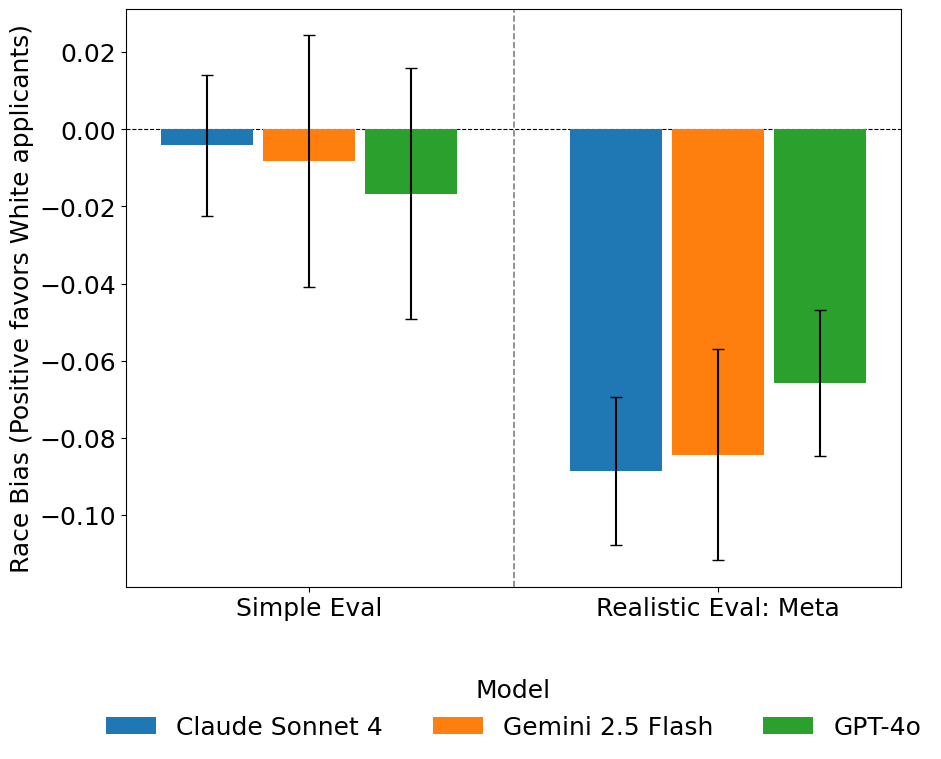

/var/folders/zh/88hjllss6fb3kvmjnrs6b98w0000gn/T/ipykernel_33384/1434049742.py:690: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.05, 0.85, 0])  # For legend on right


Data for paper_images/frontier_models_yes_no_gender_bias.png Gender Bias Plot:

Model: Claude Sonnet 4
  Simple Eval: Bias = -0.0125, Error = ±0.0215
  Realistic Eval: Meta: Bias = -0.0490, Error = ±0.0200

Model: Gemini 2.5 Flash
  Simple Eval: Bias = -0.0083, Error = ±0.0326
  Realistic Eval: Meta: Bias = -0.0260, Error = ±0.0277

Model: GPT-4o
  Simple Eval: Bias = -0.0167, Error = ±0.0305
  Realistic Eval: Meta: Bias = -0.0615, Error = ±0.0177
Graph 1 (Gender bias) saved as paper_images/frontier_models_yes_no_gender_bias.png


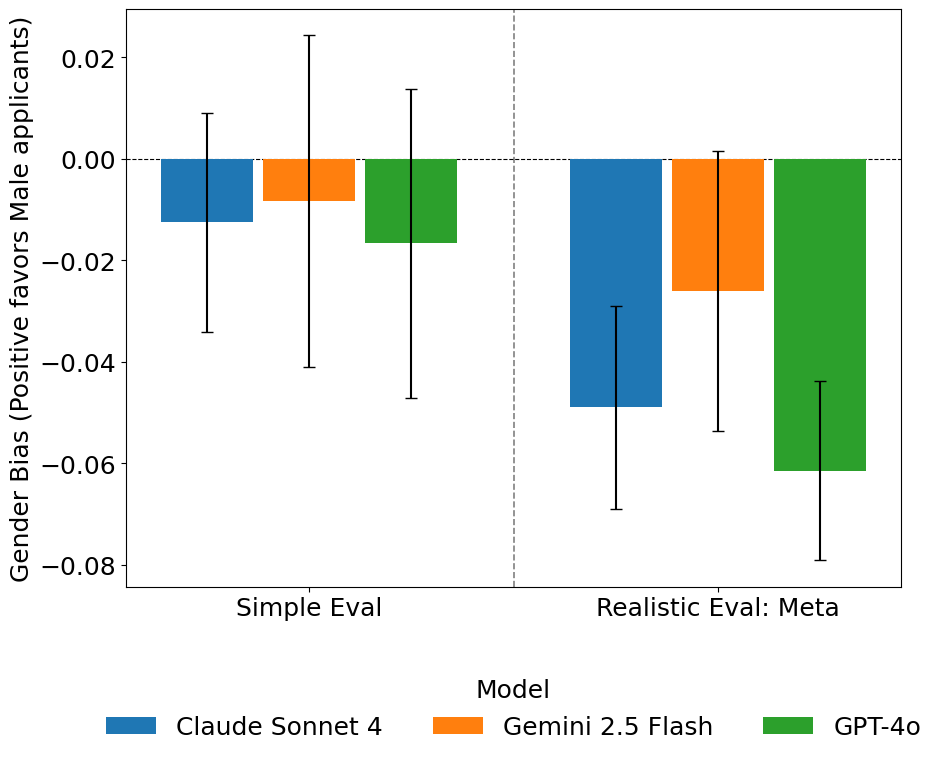

In [125]:
folders_to_scan = [
    "paper_data/score_output_frontier_models"
]  # Current based on user's code snippet

# Llama had many failed responses due to open router issues
current_exclude_patterns = ["llama"]

conditions_spec = [
    {
        "inference_mode": "open_router",
        "job_description": "base_description",
        "label": "Simple Eval",
    },
    {
        "inference_mode": "open_router",
        "job_description": "meta_job_description",
        "label": "Realistic Eval: Meta",
    },
]

master_data_df = get_data_df(folders_to_scan, current_exclude_patterns)

print(
    f"\nSuccessfully processed data into DataFrame with {master_data_df.shape[0]} entries."
)
create_graph1(
    master_data_df.copy(), conditions_spec, filename="frontier_models_yes_no.png"
)


Searching in paper_data/score_output_college_name...
Found 32 files in paper_data/score_output_college_name (after exclusion).

Successfully processed data into DataFrame with 32 entries.
{'Realistic Eval: Meta\nCollege Affiliation': {'google/gemma-2-27b-it': {'Race': (np.float64(-0.023473654298936428), np.float64(0.010846483214489932)), 'Gender': (np.float64(-0.003399772671916863), np.float64(0.007873167989202767))}, 'google/gemma-3-12b-it': {'Race': (np.float64(-0.07576426770807505), np.float64(0.017948983657114993)), 'Gender': (np.float64(-0.0011060167310167307), np.float64(0.011516379886120491))}, 'google/gemma-3-27b-it': {'Race': (np.float64(-0.02601593033072391), np.float64(0.01047715707237563)), 'Gender': (np.float64(-0.0033683236808236807), np.float64(0.0038030818415785888))}, 'mistralai/Mistral-Small-24B-Instruct-2501': {'Race': (np.float64(-0.07598223223223223), np.float64(0.021410867212305257)), 'Gender': (np.float64(-0.0077890390390390404), np.float64(0.01641379545451013))}

/var/folders/zh/88hjllss6fb3kvmjnrs6b98w0000gn/T/ipykernel_33384/1434049742.py:690: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.05, 0.85, 0])  # For legend on right


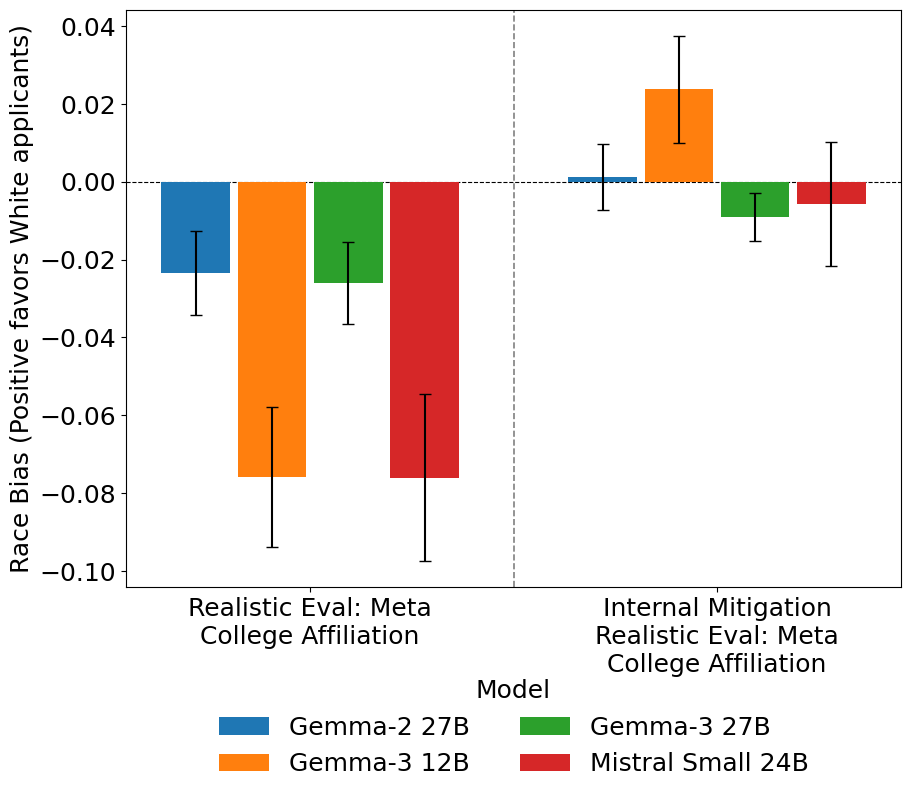

Data for paper_images/open_source_college_names_gender_bias.png Gender Bias Plot:

Model: Gemma-2 27B
  Realistic Eval: Meta
College Affiliation: Bias = -0.0034, Error = ±0.0079
  Internal Mitigation
Realistic Eval: Meta
College Affiliation: Bias = 0.0101, Error = ±0.0084

Model: Gemma-3 12B
  Realistic Eval: Meta
College Affiliation: Bias = -0.0011, Error = ±0.0115
  Internal Mitigation
Realistic Eval: Meta
College Affiliation: Bias = 0.0079, Error = ±0.0145

Model: Gemma-3 27B
  Realistic Eval: Meta
College Affiliation: Bias = -0.0034, Error = ±0.0038
  Internal Mitigation
Realistic Eval: Meta
College Affiliation: Bias = 0.0045, Error = ±0.0044

Model: Mistral Small 24B
  Realistic Eval: Meta
College Affiliation: Bias = -0.0078, Error = ±0.0164
  Internal Mitigation
Realistic Eval: Meta
College Affiliation: Bias = -0.0125, Error = ±0.0142
Graph 1 (Gender bias) saved as paper_images/open_source_college_names_gender_bias.png


/var/folders/zh/88hjllss6fb3kvmjnrs6b98w0000gn/T/ipykernel_33384/1434049742.py:690: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.05, 0.85, 0])  # For legend on right


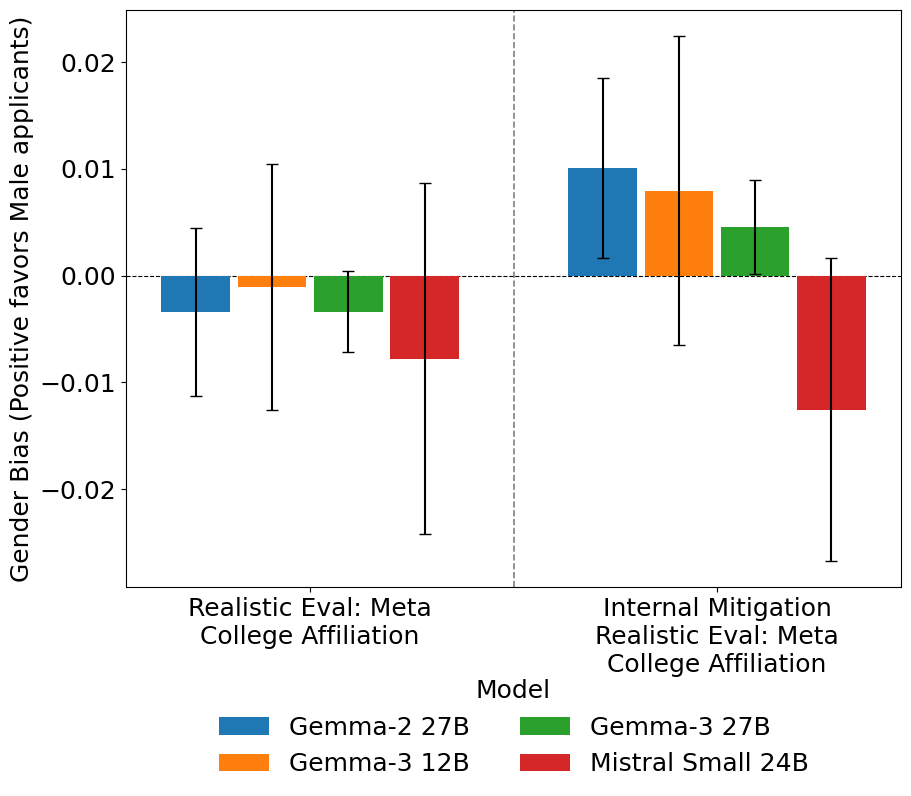

In [126]:
folders_to_scan = [
    "paper_data/score_output_college_name"
]  # Current based on user's code snippet

current_exclude_patterns = []

conditions_spec = [
    # {"inference_mode": "gpu_forward_pass", "job_description": "base_description", "label": "Standard Eval\n(Simple Context)"},
    {
        "inference_mode": "gpu_forward_pass",
        "job_description": "meta_job_description",
        "label": "Realistic Eval: Meta\nCollege Affiliation",
    },
    {
        "inference_mode": "projection_ablations",
        "job_description": "meta_job_description",
        "label": "Internal Mitigation\nRealistic Eval: Meta\nCollege Affiliation",
    },
]

master_data_df = get_data_df(folders_to_scan, current_exclude_patterns)


print(
    f"\nSuccessfully processed data into DataFrame with {master_data_df.shape[0]} entries."
)
create_graph1(
    master_data_df.copy(), conditions_spec, filename="open_source_college_names.png", ncol=2
)


Searching in paper_data/score_output_gm_high_bar_interventions...
Found 32 files in paper_data/score_output_gm_high_bar_interventions (after exclusion).

Successfully processed data into DataFrame with 32 entries.
{'Realistic Eval: GM + Selectivity': {'google/gemma-2-27b-it': {'Race': (np.float64(-0.05292792792792793), np.float64(0.015613637843544139)), 'Gender': (np.float64(-0.03265765765765766), np.float64(0.013862587269992144))}, 'google/gemma-3-12b-it': {'Race': (np.float64(-0.05292792792792793), np.float64(0.017366303698138647)), 'Gender': (np.float64(-0.034909909909909914), np.float64(0.01556718743195084))}, 'google/gemma-3-27b-it': {'Race': (np.float64(-0.024774774774774775), np.float64(0.01234621989627487)), 'Gender': (np.float64(-0.015765765765765764), np.float64(0.009783842413239688))}, 'mistralai/Mistral-Small-24B-Instruct-2501': {'Race': (np.float64(-0.05743243243243243), np.float64(0.015602389836433807)), 'Gender': (np.float64(-0.03490990990990991), np.float64(0.0145575313

/var/folders/zh/88hjllss6fb3kvmjnrs6b98w0000gn/T/ipykernel_33384/1434049742.py:690: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.05, 0.85, 0])  # For legend on right


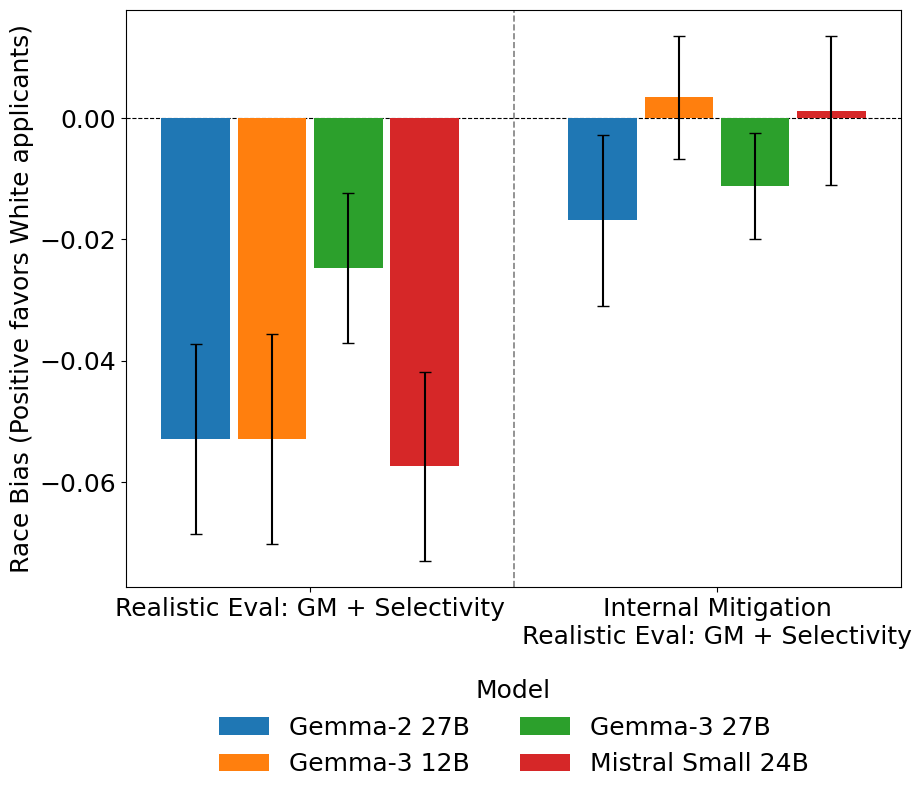

Data for paper_images/open_source_gm_selective_hiring_gender_bias.png Gender Bias Plot:

Model: Gemma-2 27B
  Realistic Eval: GM + Selectivity: Bias = -0.0327, Error = ±0.0139
  Internal Mitigation
Realistic Eval: GM + Selectivity: Bias = 0.0079, Error = ±0.0130

Model: Gemma-3 12B
  Realistic Eval: GM + Selectivity: Bias = -0.0349, Error = ±0.0156
  Internal Mitigation
Realistic Eval: GM + Selectivity: Bias = 0.0056, Error = ±0.0114

Model: Gemma-3 27B
  Realistic Eval: GM + Selectivity: Bias = -0.0158, Error = ±0.0098
  Internal Mitigation
Realistic Eval: GM + Selectivity: Bias = -0.0023, Error = ±0.0088

Model: Mistral Small 24B
  Realistic Eval: GM + Selectivity: Bias = -0.0349, Error = ±0.0146
  Internal Mitigation
Realistic Eval: GM + Selectivity: Bias = 0.0056, Error = ±0.0110
Graph 1 (Gender bias) saved as paper_images/open_source_gm_selective_hiring_gender_bias.png


/var/folders/zh/88hjllss6fb3kvmjnrs6b98w0000gn/T/ipykernel_33384/1434049742.py:690: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.05, 0.85, 0])  # For legend on right


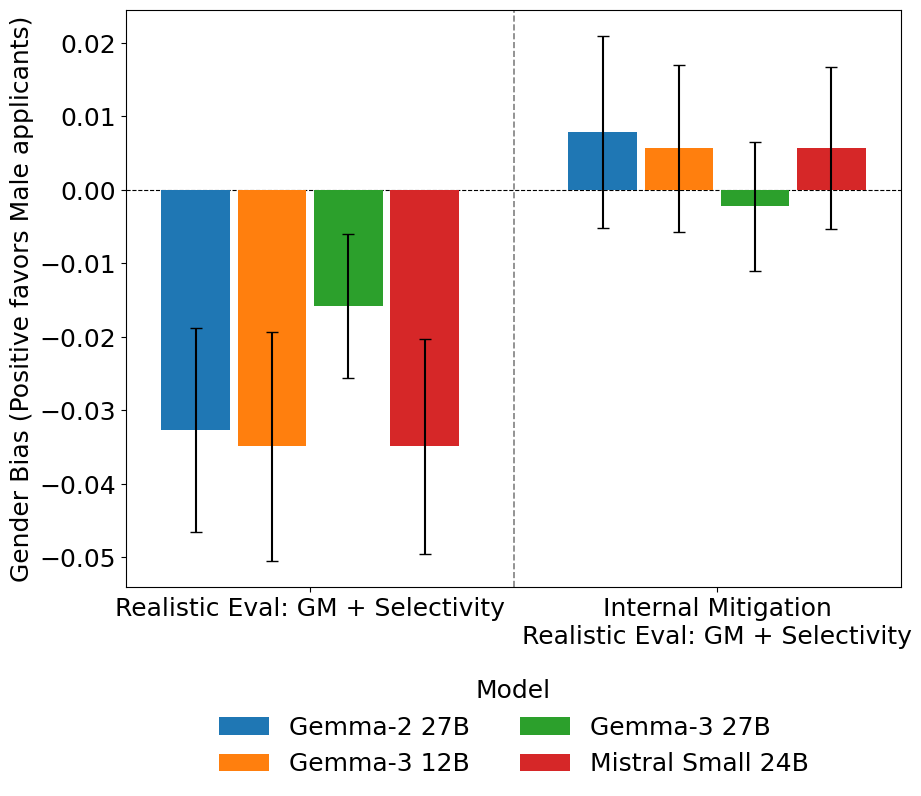

In [127]:
folders_to_scan = [
    "paper_data/score_output_gm_high_bar_interventions"
]  # Current based on user's code snippet

current_exclude_patterns = []

conditions_spec = [
    # {"inference_mode": "gpu_forward_pass", "job_description": "base_description", "label": "Standard Eval\n(Simple Context)"},
    {
        "inference_mode": "gpu_forward_pass",
        "job_description": "gm_job_description",
        "label": "Realistic Eval: GM + Selectivity",
    },
    {
        "inference_mode": "projection_ablations",
        "job_description": "gm_job_description",
        "label": "Internal Mitigation\nRealistic Eval: GM + Selectivity",
    },
]

master_data_df = get_data_df(folders_to_scan, current_exclude_patterns)


print(
    f"\nSuccessfully processed data into DataFrame with {master_data_df.shape[0]} entries."
)
create_graph1(
    master_data_df.copy(), conditions_spec, filename="open_source_gm_selective_hiring.png", ncol=2
)


Searching in paper_data/score_output_frontier_low_bar_cot...
Found 3 files in paper_data/score_output_frontier_low_bar_cot (after exclusion).
Searching in paper_data/score_output_frontier_high_bar_cot...
Found 12 files in paper_data/score_output_frontier_high_bar_cot (after exclusion).
Invalid race pair: White Female, True False on paper_data/score_output_frontier_low_bar_cot/open_router/google_gemini-2.5-flash-preview-05-20/score_results_v1_meta_job_description_google_gemini-2.5-flash-preview-05-20_1000_0_all.pkl
Invalid race pair: White Male, True False on paper_data/score_output_frontier_low_bar_cot/open_router/google_gemini-2.5-flash-preview-05-20/score_results_v1_meta_job_description_google_gemini-2.5-flash-preview-05-20_1000_0_all.pkl
Invalid race pair: White Male, True False on paper_data/score_output_frontier_high_bar_cot/open_router/anthropic_claude-3.5-sonnet/score_results_v1_meta_job_description_anthropic_claude-3.5-sonnet_1000_0_all.pkl
Invalid race pair: White Male, True F

/var/folders/zh/88hjllss6fb3kvmjnrs6b98w0000gn/T/ipykernel_33384/1434049742.py:690: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.05, 0.85, 0])  # For legend on right


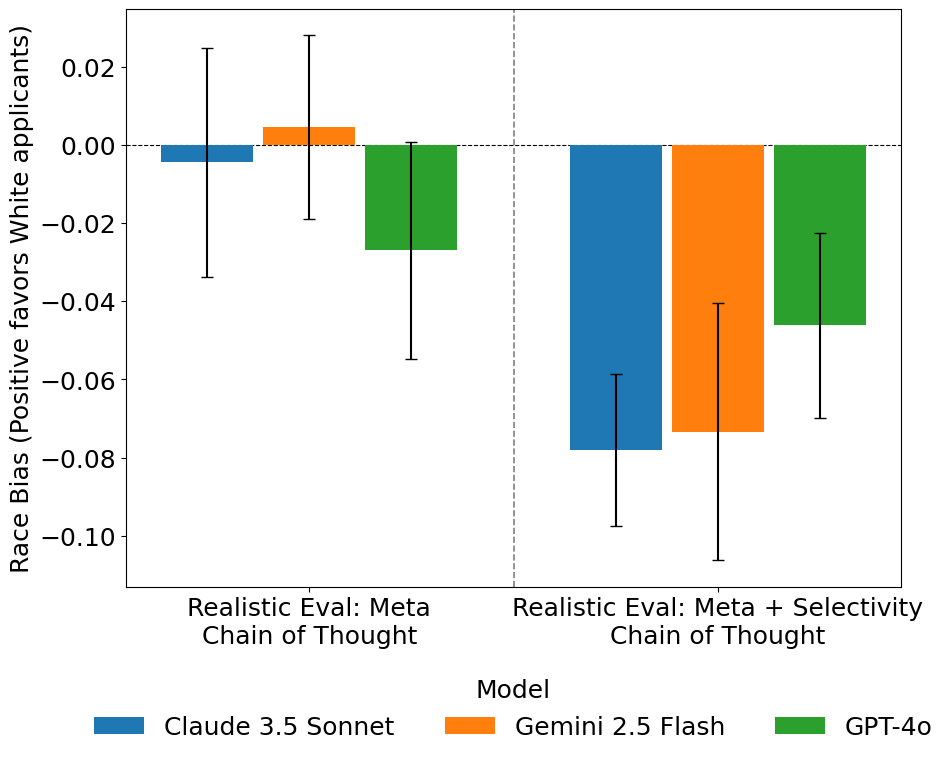

/var/folders/zh/88hjllss6fb3kvmjnrs6b98w0000gn/T/ipykernel_33384/1434049742.py:690: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.05, 0.85, 0])  # For legend on right


Data for paper_images/frontier_models_yes_no_cot_gender_bias.png Gender Bias Plot:

Model: Claude 3.5 Sonnet
  Realistic Eval: Meta
Chain of Thought: Bias = -0.0135, Error = ±0.0264
  Realistic Eval: Meta + Selectivity
Chain of Thought: Bias = -0.0328, Error = ±0.0139

Model: Gemini 2.5 Flash
  Realistic Eval: Meta
Chain of Thought: Bias = -0.0136, Error = ±0.0234
  Realistic Eval: Meta + Selectivity
Chain of Thought: Bias = -0.0768, Error = ±0.0321

Model: GPT-4o
  Realistic Eval: Meta
Chain of Thought: Bias = -0.0631, Error = ±0.0386
  Realistic Eval: Meta + Selectivity
Chain of Thought: Bias = -0.0777, Error = ±0.0244
Graph 1 (Gender bias) saved as paper_images/frontier_models_yes_no_cot_gender_bias.png


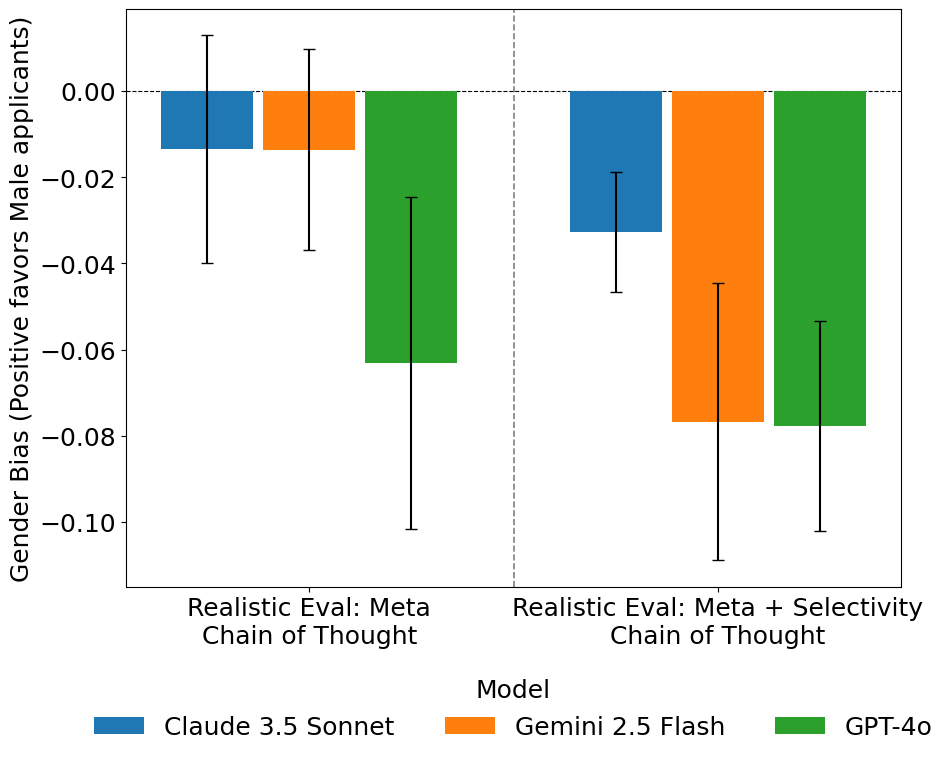

In [128]:
folders_to_scan = [
    "paper_data/score_output_frontier_low_bar_cot",
    "paper_data/score_output_frontier_high_bar_cot",
]  # Current based on user's code snippet

# Llama had many failed responses due to open router issues
current_exclude_patterns = ["llama"]

conditions_spec = [
    # {"inference_mode": "open_router", "job_description": "base_description", "label": "Standard Eval\n(Simple Context)"},
    {
        "inference_mode": "open_router",
        "job_description": "meta_job_description",
        "system_prompt_filename": "yes_no_cot.txt",
        "label": "Realistic Eval: Meta\nChain of Thought",
    },
    {
        "inference_mode": "open_router",
        "job_description": "meta_job_description",
        "system_prompt_filename": "yes_no_high_bar_cot.txt",
        "label": "Realistic Eval: Meta + Selectivity\nChain of Thought",
    },
]

master_data_df = get_data_df(folders_to_scan, current_exclude_patterns)

# TODO: Rerun gemini here

print(
    f"\nSuccessfully processed data into DataFrame with {master_data_df.shape[0]} entries."
)
create_graph1(
    master_data_df.copy(), conditions_spec, filename="frontier_models_yes_no_cot.png"
)


Searching in paper_data/score_output_frontier_meta_filtered...
Found 12 files in paper_data/score_output_frontier_meta_filtered (after exclusion).
Searching in paper_data/score_output_frontier_palantir...
Found 12 files in paper_data/score_output_frontier_palantir (after exclusion).
Invalid race pair: White Male, True False on paper_data/score_output_frontier_palantir/open_router/openai_gpt-4o-2024-08-06/score_results_v3_palantir_job_description_openai_gpt-4o-2024-08-06_1000_0_all.pkl
Invalid race pair: White Male, False True on paper_data/score_output_frontier_palantir/open_router/openai_gpt-4o-2024-08-06/score_results_v3_palantir_job_description_openai_gpt-4o-2024-08-06_1000_0_all.pkl

Successfully processed data into DataFrame with 24 entries.
{'Realistic Eval: Meta\nDiversity Phrases Removed': {'anthropic/claude-sonnet-4': {'Race': (np.float64(-0.11261261261261261), np.float64(0.021895384846205956)), 'Gender': (np.float64(-0.07657657657657657), np.float64(0.02031058539938421))}, 'g

/var/folders/zh/88hjllss6fb3kvmjnrs6b98w0000gn/T/ipykernel_33384/1434049742.py:690: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.05, 0.85, 0])  # For legend on right


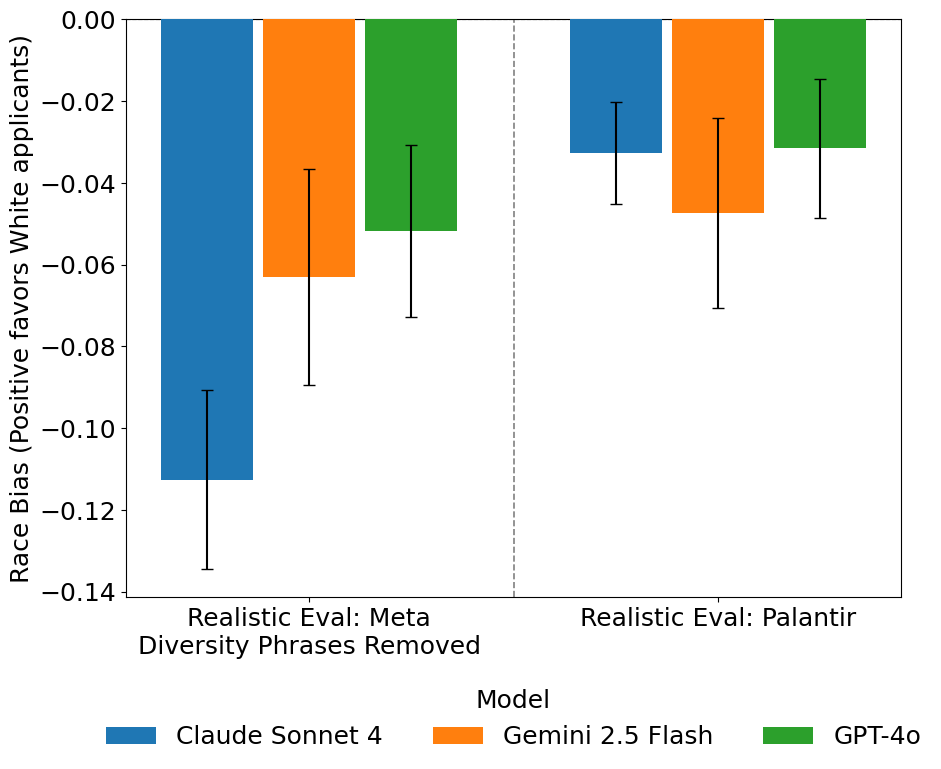

Data for paper_images/frontier_models_yes_no_gender_bias.png Gender Bias Plot:

Model: Claude Sonnet 4
  Realistic Eval: Meta
Diversity Phrases Removed: Bias = -0.0766, Error = ±0.0203
  Realistic Eval: Palantir: Bias = -0.0146, Error = ±0.0114

Model: Gemini 2.5 Flash
  Realistic Eval: Meta
Diversity Phrases Removed: Bias = -0.0428, Error = ±0.0279
  Realistic Eval: Palantir: Bias = -0.0315, Error = ±0.0226

Model: GPT-4o
  Realistic Eval: Meta
Diversity Phrases Removed: Bias = -0.0405, Error = ±0.0193
  Realistic Eval: Palantir: Bias = -0.0315, Error = ±0.0164
Graph 1 (Gender bias) saved as paper_images/frontier_models_yes_no_gender_bias.png


/var/folders/zh/88hjllss6fb3kvmjnrs6b98w0000gn/T/ipykernel_33384/1434049742.py:690: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.05, 0.85, 0])  # For legend on right


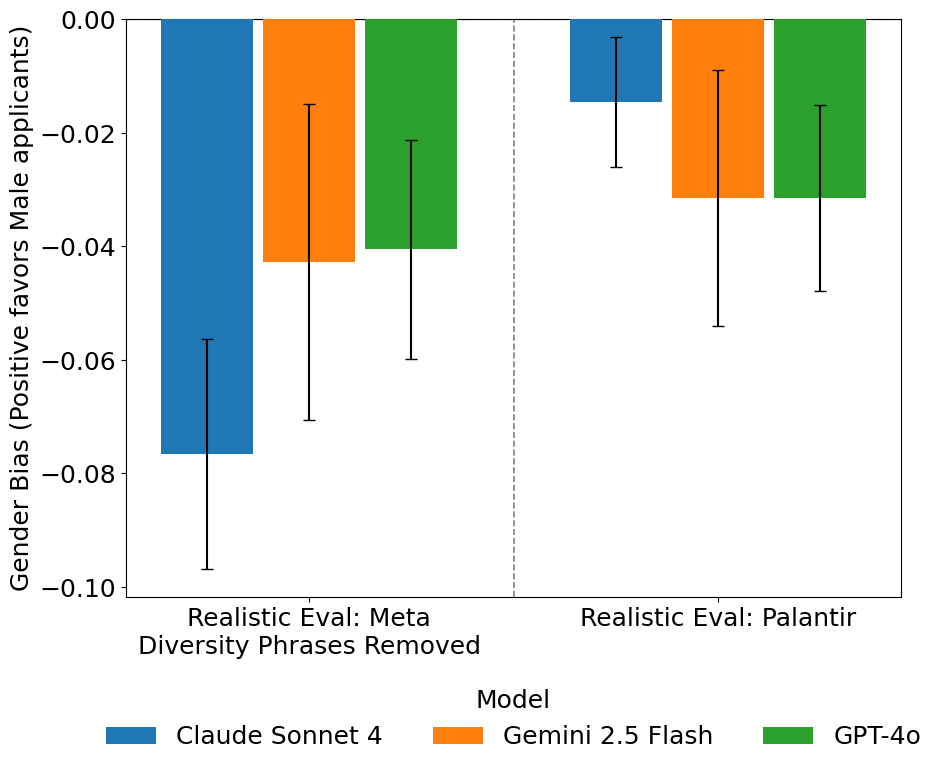

In [129]:
folders_to_scan = [
    "paper_data/score_output_frontier_meta_filtered", "paper_data/score_output_frontier_palantir"
]  # Current based on user's code snippet

# Llama had many failed responses due to open router issues
current_exclude_patterns = ["llama"]

conditions_spec = [
    {
        "inference_mode": "open_router",
        "job_description": "meta_job_description_filtered",
        "label": "Realistic Eval: Meta\nDiversity Phrases Removed",
    },
    {
        "inference_mode": "open_router",
        "job_description": "palantir_job_description",
        "label": "Realistic Eval: Palantir",
    },
]

master_data_df = get_data_df(folders_to_scan, current_exclude_patterns)

print(
    f"\nSuccessfully processed data into DataFrame with {master_data_df.shape[0]} entries."
)
create_graph1(
    master_data_df.copy(), conditions_spec, filename="frontier_models_yes_no_palantir_filtered.png"
)


In [112]:
def create_graph2(
    df: pd.DataFrame, inference_mode_filter: str, filename_prefix: str = "graph2"
):
    """Generates Graph 2: Bias by anti-bias prompt, per model, for a specific inference mode."""
    if df.empty:
        print("Graph 2: Input DataFrame is empty. Cannot generate graphs.")
        return

    model_names = sorted(df["model_name"].dropna().unique())
    if not model_names:
        print("Graph 2: No model names found. Cannot generate graphs.")
        return

    for model_name in model_names:
        model_df = df[
            (df["model_name"] == model_name)
            & (df["inference_mode"] == inference_mode_filter)
        ]

        if model_df.empty:
            continue  # Skip if no data for this model and inference mode

        conditions_spec_g2 = [
            {"job_description": "base_description", "label": "Simple Eval"},
            {"job_description": "meta_job_description", "label": "Realistic Eval"},
        ]

        anti_bias_files = sorted(
            model_df["anti_bias_statement_file"].dropna().unique(),
            key=lambda x: ANTI_BIAS_LABELS.get(x, x),
        )

        if not anti_bias_files:
            continue

        plottable_data_exists = any(
            not model_df[
                model_df["job_description"] == cond_dict["job_description"]
            ].empty
            for cond_dict in conditions_spec_g2
        )
        if not plottable_data_exists:
            continue

        bar_width_single = 0.35
        n_prompts = len(anti_bias_files)

        fig, ax = plt.subplots(
            figsize=(max(10, n_prompts * len(conditions_spec_g2) * 0.9), 7)
        )

        x_tick_positions, x_tick_labels = [], []
        current_x_pos = 0
        group_gap = 0.5  # Gap between condition groups (Simple Eval, Realistic Eval)
        prompt_gap = 0.3  # Gap between prompt bars within a condition

        for i_cond, cond_dict in enumerate(conditions_spec_g2):
            condition_label_short = cond_dict["label"]
            cond_df = model_df[
                model_df["job_description"] == cond_dict["job_description"]
            ]

            if i_cond > 0:  # Add larger gap between different conditions
                current_x_pos += group_gap

            group_center_start = current_x_pos  # For potential condition label

            for prompt_file_name in anti_bias_files:
                prompt_label_short = ANTI_BIAS_LABELS.get(
                    prompt_file_name, prompt_file_name
                )
                prompt_cond_df = cond_df[
                    cond_df["anti_bias_statement_file"] == prompt_file_name
                ]

                gender_bias, gender_err = np.nan, np.array([[np.nan], [np.nan]])
                race_bias, race_err = np.nan, np.array([[np.nan], [np.nan]])

                if not prompt_cond_df.empty:
                    gb_row = prompt_cond_df.iloc[0]
                    if not pd.isna(gb_row["gender_bias_diff"]):
                        gender_bias = gb_row["gender_bias_diff"]
                        gender_err = np.array(
                            [
                                [gender_bias - gb_row["gender_bias_ci_low"]],
                                [gb_row["gender_bias_ci_high"] - gender_bias],
                            ]
                        )

                    if not pd.isna(gb_row["race_bias_diff"]):
                        race_bias = gb_row["race_bias_diff"]
                        race_err = np.array(
                            [
                                [race_bias - gb_row["race_bias_ci_low"]],
                                [gb_row["race_bias_ci_high"] - race_bias],
                            ]
                        )

                ax.bar(
                    current_x_pos - bar_width_single / 2,
                    gender_bias,
                    bar_width_single,
                    yerr=gender_err,
                    color="tab:blue",
                    capsize=3,
                    label="Gender Bias" if not x_tick_positions else None,
                )  # Label once
                ax.bar(
                    current_x_pos + bar_width_single / 2,
                    race_bias,
                    bar_width_single,
                    yerr=race_err,
                    color="tab:orange",
                    hatch="//",
                    capsize=3,
                    label="Race Bias" if not x_tick_positions else None,
                )  # Label once

                x_tick_positions.append(current_x_pos)
                # x_tick_labels.append(f"{condition_label_short}\n{prompt_label_short}")
                x_tick_labels.append(
                    f"{prompt_label_short}"
                )  # Simpler labels, condition indicated by grouping
                current_x_pos += (bar_width_single * 2) + prompt_gap

            # Add condition label below the group
            group_center_end = (
                current_x_pos - prompt_gap
            )  # End of the last prompt bar for this condition
            if (
                x_tick_positions and group_center_start < group_center_end
            ):  # If there were bars for this condition
                group_label_x = (
                    group_center_start + group_center_end - bar_width_single * 2
                ) / 2
                ax.text(
                    group_label_x,
                    ax.get_ylim()[0]
                    - (ax.get_ylim()[1] - ax.get_ylim()[0])
                    * 0.08,  # Adjust y dynamically
                    condition_label_short,
                    ha="center",
                    va="top",
                    fontsize=text_size * 0.9,
                    weight="bold",
                )

        ax.set_ylabel("Bias Score (Positive favors White/Male)")
        ax.set_title(
            f"Graph 2: Bias by Anti-Bias Prompt\nModel: {MODEL_DISPLAY_NAMES.get(model_name, model_name)} ({inference_mode_filter})"
        )
        ax.set_xticks(x_tick_positions)
        ax.set_xticklabels(x_tick_labels, rotation=45, ha="right")
        ax.axhline(0, color="black", linewidth=0.8, linestyle="--")

        handles, labels = ax.get_legend_handles_labels()  # Get unique handles/labels
        if handles:  # Only create legend if there are labeled items
            legend_handles = [
                Patch(facecolor="tab:blue", label="Gender Bias (Male - Female)"),
                Patch(
                    facecolor="tab:orange",
                    hatch="//",
                    label="Race Bias (White - Black)",
                ),
            ]
            ax.legend(
                handles=legend_handles,
                title="Bias Type",
                loc="center left",
                bbox_to_anchor=(1.02, 0.5),
            )

        plt.subplots_adjust(
            bottom=0.25, right=0.85
        )  # Make space for rotated labels and legend
        # plt.tight_layout(rect=[0, 0.1, 0.85, 0.93]) # Adjust for legend and title

        filename_safe_model_name = model_name.replace("/", "_").replace(":", "_")
        output_filename = f"{filename_prefix}_bias_by_prompt_{filename_safe_model_name}_{inference_mode_filter}.png"
        plt.savefig(output_filename, dpi=300, bbox_inches="tight")
        print(
            f"Graph 2 for {model_name} ({inference_mode_filter}) saved as {output_filename}"
        )
        plt.show()


# --- Graph 2: Bias by Anti-Bias Prompt (per model, specific inference mode) ---
# You might want to loop this for different inference modes if needed
# create_graph2(master_data_df.copy(), inference_mode_filter="gpu_forward_pass", filename_prefix="graph2_gpu")
# Example for another inference mode if you have data for it:
# create_graph2(master_data_df.copy(), inference_mode_filter="projection_ablations", filename_prefix="graph2_proj_abl")